<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/NorthwesternHeader.png?raw=1">

## MSDS458 Research Assignment 2
<div class="alert alert-block alert-success">
    <b>More Technical</b>: Throughout the notebook. This types of boxes provide more technical details and extra references about what you are seeing. They contain helpful tips, but you can safely skip them the first time you run through the code.
</div><br>

The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class.

<div class="alert alert-block alert-info">
<b>The CIFAR-10 dataset</b><br>
https://www.cs.toronto.edu/~kriz/cifar.html
    </div>

## Import packages needed 

In [1]:
# Helper libraries
import datetime
from packaging import version
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from collections import Counter
import numpy as np
import pandas as pd

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense

In [2]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

### Verify TensorFlow Version and Keras Version

In [3]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.3.0


In [4]:
print("Keras version: ", keras.__version__)

Keras version:  2.4.0


<div class="alert alert-block alert-info">
    <b>Suppress warning messages</b></div>

In [5]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

### Mount Google Drive to Colab Enviorment

In [6]:
# from google.colab import drive
# drive.mount('/content/gdrive')

## Loading cifar10 Dataset

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.<br>

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.


In [7]:
(train_images, train_labels),(test_images, test_labels)= tf.keras.datasets.cifar10.load_data()

* Tuple of Numpy arrays: (x_train, y_train), (x_test, y_test).
* x_train, x_test: uint8 arrays of color image data with shapes (num_samples, 32, 32).
* y_train, y_test: uint8 arrays of digit labels (integers in range 0-9)

## EDA Training and Test Datasets

* Imported 50000 examples for training and 10000 examples for test 
* Imported 50000 labels for training and 10000 labels for test 

In [8]:
print('train_images:\t{}'.format(train_images.shape))
print('train_labels:\t{}'.format(train_labels.shape))
print('test_images:\t\t{}'.format(test_images.shape))
print('test_labels:\t\t{}'.format(test_labels.shape))

train_images:	(50000, 32, 32, 3)
train_labels:	(50000, 1)
test_images:		(10000, 32, 32, 3)
test_labels:		(10000, 1)


### Review labels for training dataset

In [9]:
print("First ten labels training dataset:\n {}\n".format(train_labels[0:10]))
print("This output the numeric label, need to convert to item description")

First ten labels training dataset:
 [[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]

This output the numeric label, need to convert to item description


### Plot Examples

In [10]:
def get_three_classes(x, y):
    def indices_of(class_id):
        indices, _ = np.where(y == float(class_id))
        return indices

    indices = np.concatenate([indices_of(0), indices_of(1), indices_of(2)], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [11]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [12]:
x_preview, y_preview = get_three_classes(x_train, y_train)
x_preview, y_preview = get_three_classes(x_test, y_test)

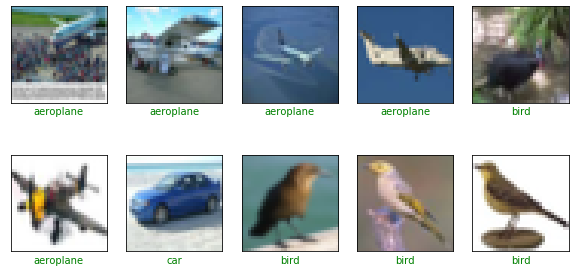

In [13]:
class_names_preview = ['aeroplane', 'car', 'bird']

def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names_preview[np.argmax(p[i])], color=col)
    plt.show()

show_random_examples(x_preview, y_preview, y_preview)

### Random Review of Examples 

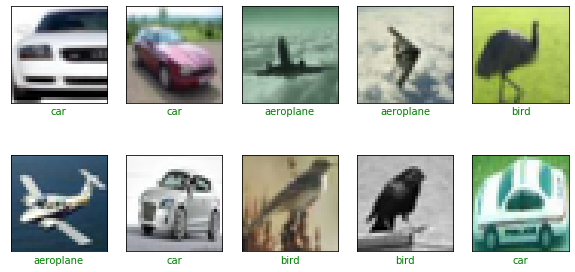

In [14]:
show_random_examples(x_preview, y_preview, y_preview)

## Preprocessing Data for Model Development

The labels are an array of integers, ranging from 0 to 9. These correspond to the class of clothing the image represents:

|Label  |Class_  |
|-------|--------|
|0|	airplane     |
|1|	automobile   |
|2|	bird         |
|3|	cat          |
|4|	deer         |
|5|	dog          |
|6|	frog         |
|7|	horse        |
|8|	ship         |
|9|	truck        |

In [15]:
class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

### Preprocessing the Examples
 The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255.
 

1. Each element in each example is a pixel value
2. Pixel values range from 0 to 255
3. 0 = black
4. 255 = white

In [16]:
train_images_norm = train_images.astype('float32')/255.
test_images_norm = test_images.astype('float32')/255.

In [17]:
train_images_norm.shape, test_images_norm.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

## Validating our approach

10,000 samples of our training data to use as a validation set. 

In [18]:
val_images_norm, train_images_norm = train_images_norm[:3000], train_images_norm[3000:] 
val_labels, train_labels = train_labels[:3000], train_labels[3000:]

In [19]:
val_images_norm.shape, val_labels.shape

((3000, 32, 32, 3), (3000, 1))

In [20]:
train_images_norm.shape, train_labels.shape

((47000, 32, 32, 3), (47000, 1))

## Create the Model

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/CNN_architecture_v4.png?raw=1">


### Build CNN Model

We use a Sequential class defined in Keras to create our model. The first 4 layers Conv2D and MaxPooling handle feature learning.  The last 3 layers, handle classification.  

In [21]:
model = models.Sequential()
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(32, 32, 3)))
model.add(layers.MaxPool2D((2, 2),strides=2))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model.add(layers.Dropout(0.3))
model.add(layers.Flatten())
model.add(layers.Dense(units=384, activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model.add(layers.Dense(units=10, activation=tf.nn.softmax))

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 128)       3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 256)       295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 256)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 512)         1

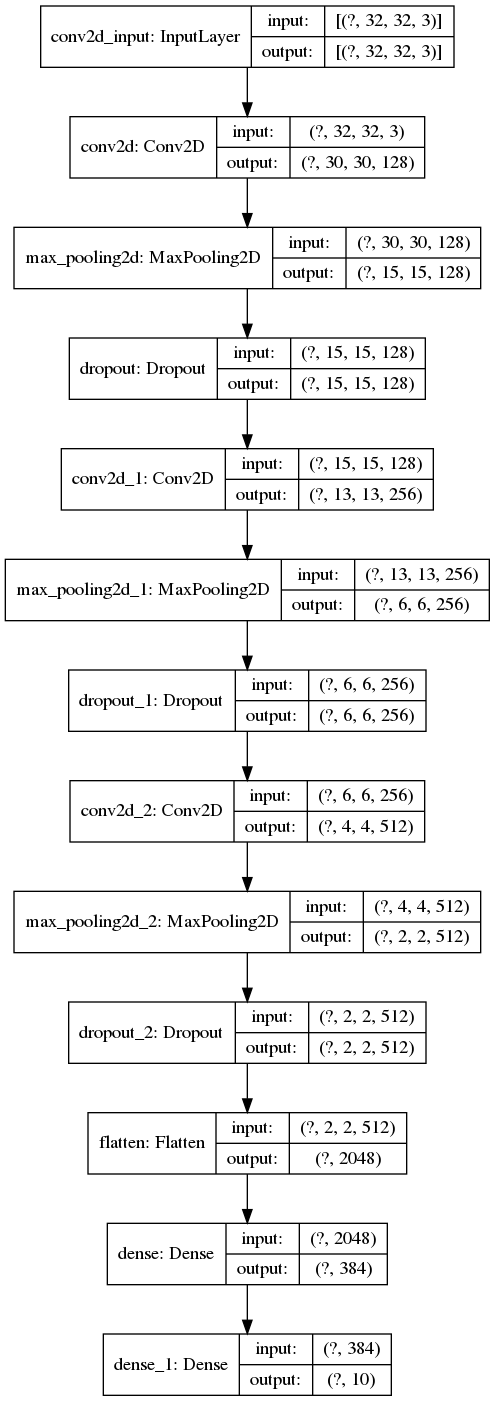

In [23]:
keras.utils.plot_model(model, "CIFAR10.png", show_shapes=True) 

### Compiling the model

In addition to setting up our model architecture, we also need to define which algorithm should the model use in order to optimize the weights and biases as per the given data. We will use stochastic gradient descent.

We also need to define a loss function. Think of this function as the difference between the predicted outputs and the actual outputs given in the dataset. This loss needs to be minimised in order to have a higher model accuracy. That's what the optimization algorithm essentially does - it minimises the loss during model training. For our multi-class classification problem, categorical cross entropy is commonly used.

Finally, we will use the accuracy during training as a metric to keep track of as the model trains.

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

## Training the model

<div class="alert alert-block alert-success">
    <b>Module: tf.keras.callbacks</b></div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.EarlyStopping</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping</div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.ModelCheckpoint</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint</div>

In [25]:
history = model.fit(train_images_norm
                    ,train_labels
                    ,epochs=200
                    ,batch_size=512
                    ,validation_data=(val_images_norm,val_labels)
                    ,callbacks=[
                    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    tf.keras.callbacks.ModelCheckpoint('./models/model_{val_accuracy:.4f}.h5', save_best_only=True,
                                        save_weights_only=False, monitor='val_accuracy')]                                                                                                           
                   )

Epoch 1/200
92/92 [==============================] - 632s 7s/step - loss: 2.1078 - accuracy: 0.3142 - val_loss: 1.6745 - val_accuracy: 0.4397
Epoch 2/200
92/92 [==============================] - 634s 7s/step - loss: 1.5292 - accuracy: 0.4807 - val_loss: 1.3347 - val_accuracy: 0.5573
Epoch 3/200
92/92 [==============================] - 629s 7s/step - loss: 1.3446 - accuracy: 0.5470 - val_loss: 1.1938 - val_accuracy: 0.6057
Epoch 4/200
92/92 [==============================] - 630s 7s/step - loss: 1.2191 - accuracy: 0.5926 - val_loss: 1.0730 - val_accuracy: 0.6467
Epoch 5/200
92/92 [==============================] - 629s 7s/step - loss: 1.1161 - accuracy: 0.6326 - val_loss: 0.9927 - val_accuracy: 0.6777
Epoch 6/200
92/92 [==============================] - 628s 7s/step - loss: 1.0365 - accuracy: 0.6569 - val_loss: 0.9185 - val_accuracy: 0.7127
Epoch 7/200
92/92 [==============================] - 628s 7s/step - loss: 0.9715 - accuracy: 0.6820 - val_loss: 0.8876 - val_accuracy: 0.7090
Epoch 

### Validation Data
Data on which to evaluate the loss and any model metrics at the end of each epoch<br>
The model will not be trained on this data

## Evaluate the model

In order to ensure that this is not a simple "memorization" by the machine, we should evaluate the performance on the test set. This is easy to do, we simply use the `evaluate` method on our model.

In [26]:
loss, accuracy = model.evaluate(test_images_norm, test_labels)
print('test set accuracy: ', accuracy * 100)

313/313 [==============================] - 35s 113ms/step - loss: 0.7531 - accuracy: 0.7688
test set accuracy:  76.88000202178955


## Predictions

In [27]:
preds = model.predict(test_images_norm)
print('shape of preds: ', preds.shape)

shape of preds:  (10000, 10)


## Plotting Performance Metrics 

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [28]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [29]:
history_df=pd.DataFrame(history_dict)
history_df.tail()

,loss,accuracy,val_loss,val_accuracy
14,0.727353,0.771213,0.716389,0.778667
15,0.705440,0.778681,0.706366,0.783333
16,0.693322,0.782043,0.732659,0.772000
17,0.673582,0.789277,0.711250,0.781333
18,0.642626,0.800596,0.713851,0.782000


In [30]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

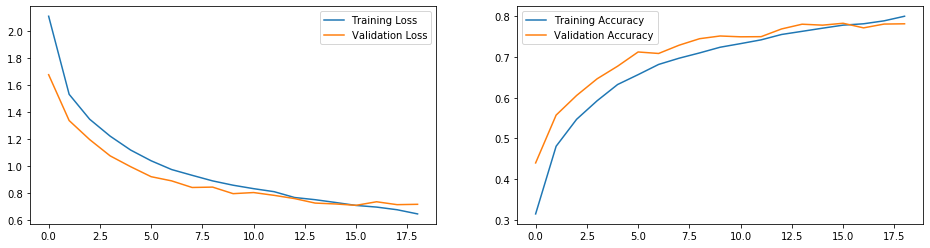

In [31]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

## Confusion matrices

Let us see what the confusion matrix looks like. Using both `sklearn.metrics`. Then we visualize the confusion matrix and see what that tells us.

Get the predicted classes

In [32]:
pred_classes = np.argmax(model.predict(train_images_norm), axis=-1)
pred_classes

array([3, 5, 5, ..., 9, 1, 1])

### Visualizing the confusion matrix

In [33]:
conf_mx = tf.math.confusion_matrix(train_labels, pred_classes)
conf_mx

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[4209,   12,   90,   91,   44,   17,   20,   13,   94,  111],
       [  36, 4174,   17,   45,    1,   15,   25,    5,   35,  360],
       [ 150,    0, 3396,  322,  273,  202,  249,   43,   19,   24],
       [  16,    1,   72, 3985,   77,  394,  119,   20,   15,   16],
       [  25,    1,   65,  229, 4104,   94,  119,   38,    9,    5],
       [   6,    0,   40,  690,  114, 3753,   56,   53,    5,    4],
       [   5,    3,   39,  221,   38,   41, 4322,    2,    8,    9],
       [  11,    0,   44,  194,  221,  190,   13, 4007,    6,   17],
       [ 153,   35,   16,   52,    7,   18,   11,    3, 4324,   73],
       [  48,   32,    8,   54,    4,   29,   15,    4,   47, 4459]],
      dtype=int32)>

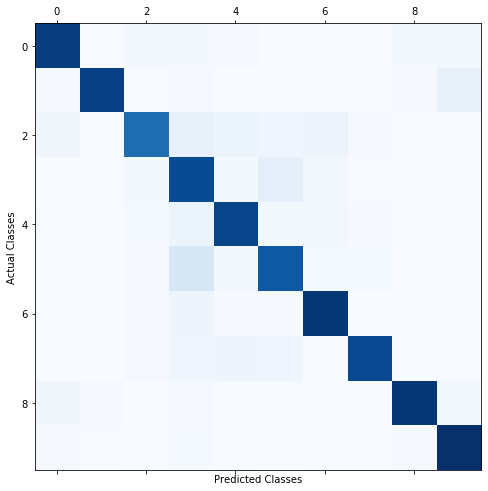

In [34]:
plt.figure(figsize=(16,8))
plt.matshow(conf_mx, cmap=plt.cm.Blues,fignum=1)
plt.xlabel("Predicted Classes")
plt.ylabel("Actual Classes")
plt.show()

### Load HDF5 Model Format 

<div class="alert alert-block alert-info">
<b>tf.keras.models.load_model</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/models/load_model</div>

In [35]:
model = tf.keras.models.load_model('./models/model_0.8137.h5')

In [36]:
preds = model.predict(train_images_norm)

In [37]:
preds.shape

(47000, 10)

In [38]:
print("The first predictions\n {}\n".format(preds[0]))

The first predictions
 [0.034 0.001 0.026 0.537 0.226 0.02  0.108 0.032 0.009 0.007]



In [39]:
print(class_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [40]:
print("First ten entries of the predictions:\n {}\n".format(preds[0:20]))

First ten entries of the predictions:
 [[0.034 0.001 0.026 0.537 0.226 0.02  0.108 0.032 0.009 0.007]
 [0.013 0.    0.008 0.024 0.782 0.097 0.001 0.075 0.    0.   ]
 [0.001 0.    0.006 0.23  0.045 0.615 0.006 0.096 0.    0.   ]
 [0.002 0.001 0.018 0.711 0.001 0.24  0.003 0.025 0.    0.   ]
 [0.    0.    0.001 0.    0.    0.    0.998 0.    0.    0.   ]
 [0.001 0.    0.011 0.134 0.012 0.763 0.075 0.004 0.    0.   ]
 [0.    0.008 0.    0.    0.    0.    0.    0.    0.001 0.991]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.999]
 [0.005 0.    0.007 0.281 0.061 0.115 0.016 0.51  0.001 0.003]
 [0.03  0.952 0.    0.    0.    0.    0.    0.    0.011 0.006]
 [0.    0.    0.001 0.003 0.    0.    0.996 0.    0.    0.   ]
 [0.931 0.004 0.001 0.001 0.    0.    0.    0.    0.008 0.054]
 [0.065 0.    0.902 0.007 0.002 0.002 0.019 0.002 0.001 0.   ]
 [0.    0.001 0.    0.    0.003 0.    0.    0.992 0.    0.003]
 [0.013 0.007 0.016 0.02  0.003 0.002 0.003 0.034 0.001 0.902]
 [0.    0.    0.

### Predictions

In [41]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [42]:
df = pd.DataFrame(preds[0:20], columns = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
0,3.38%,0.12%,2.59%,53.73%,22.60%,2.00%,10.78%,3.19%,0.94%,0.67%
1,1.28%,0.00%,0.82%,2.35%,78.19%,9.69%,0.13%,7.51%,0.02%,0.01%
2,0.05%,0.05%,0.63%,22.99%,4.48%,61.49%,0.63%,9.63%,0.01%,0.03%
3,0.19%,0.06%,1.77%,71.10%,0.07%,24.04%,0.26%,2.46%,0.01%,0.04%
4,0.00%,0.00%,0.15%,0.02%,0.02%,0.01%,99.80%,0.00%,0.00%,0.00%
5,0.11%,0.01%,1.13%,13.38%,1.20%,76.30%,7.49%,0.36%,0.00%,0.02%
6,0.03%,0.84%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.06%,99.07%
7,0.03%,0.02%,0.00%,0.00%,0.00%,0.01%,0.00%,0.00%,0.01%,99.94%
8,0.48%,0.05%,0.68%,28.15%,6.12%,11.46%,1.64%,51.03%,0.12%,0.28%
9,3.02%,95.23%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,1.15%,0.59%


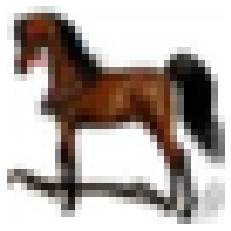

In [43]:
from tensorflow.keras.preprocessing import image
# import numpy as np

(_,_), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

img = test_images[2004]
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

# https://www.tensorflow.org/tutorials/keras/classification
class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

plt.imshow(img, cmap='viridis')
plt.axis('off')
#plt.title(class_names[test_labels[0]], fontsize=12)
plt.show()

In [44]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [45]:
activations = activation_model.predict(img_tensor)
len(activations)

8

In [46]:
layer_names = []
for layer in model.layers:
    layer_names.append(layer.name)
    
layer_names

['conv2d',
 'max_pooling2d',
 'dropout',
 'conv2d_1',
 'max_pooling2d_1',
 'dropout_1',
 'conv2d_2',
 'max_pooling2d_2',
 'dropout_2',
 'flatten',
 'dense',
 'dense_1']

/home/jensen116/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


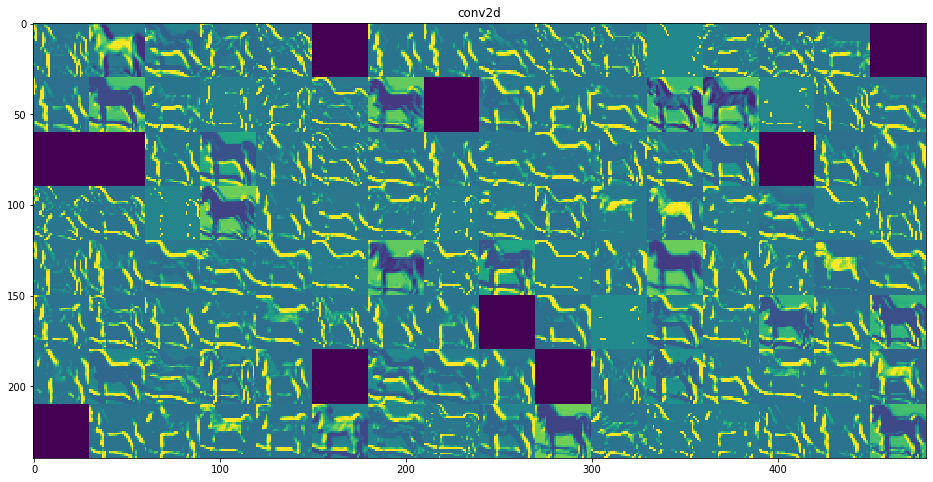

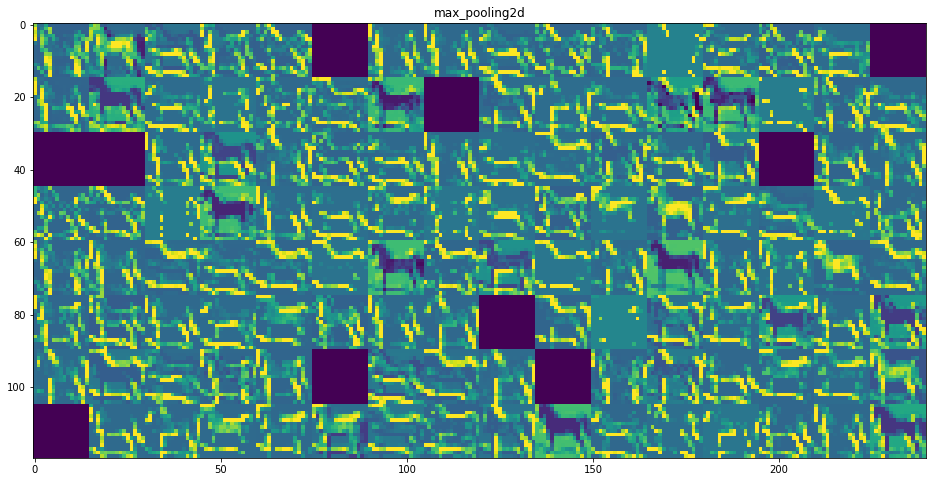

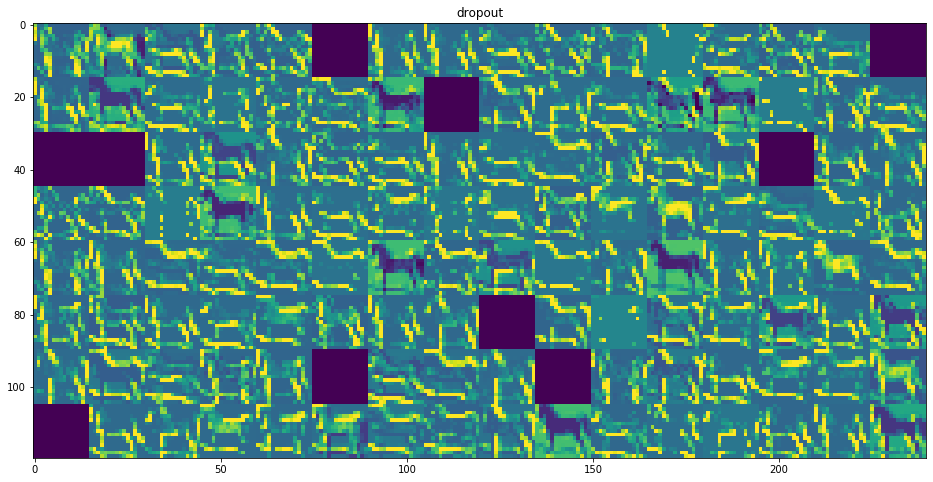

In [47]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:3]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()